In [25]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import torch.optim as optim
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt

def mlr(gene_df, cell_df, highlight='gene_42'):
    # Summing up the well_read_fraction for each well_id and gene_id combination
    gene_df_agg = gene_df.groupby(['well_id', 'gene_id'])['well_read_fraction'].sum().reset_index()

    # Pivot the gene dataframe to create a matrix of genes per well
    gene_matrix = gene_df_agg.pivot(index='well_id', columns='gene_id', values='well_read_fraction').fillna(0)
    
    # Ensure that 'well_id' is a column for merging
    gene_matrix.reset_index(inplace=True)

    # Merge the cell dataframe with the gene matrix on the well_id
    merged_df = pd.merge(cell_df, gene_matrix, on='well_id', how='inner')

    # The independent variables X are all the gene columns, and the dependent variable y is the 'score'
    X = merged_df.drop(columns=['cell_id', 'well_id', 'score'])
    y = merged_df['score']

    # Add a constant to the model for the intercept
    X_with_const = sm.add_constant(X, prepend=False)

    # Fit the ordinary least squares (OLS) model
    model = sm.OLS(y, X_with_const).fit()

    # Prepare data for volcano plot
    coefficients = model.params.drop('const')  # exclude the intercept
    log_p_values = -np.log10(model.pvalues.drop('const'))  # exclude the intercept p-value
    volcano_df = pd.DataFrame({'Gene': coefficients.index, 'LogP': log_p_values, 'Coefficients': coefficients.values})

    # Plotting the volcano plot
    plt.figure(figsize=(10, 6))
    plt.scatter(volcano_df['Coefficients'], volcano_df['LogP'], color='blue', label='All Genes')
    plt.xlabel('Coefficients')
    plt.ylabel('-Log10(p-value)')
    plt.title('Volcano Plot of MLR Coefficients vs. P-values')
    plt.axhline(y=-np.log10(0.05), color='r', linestyle='--', label='p=0.05')  # significance line at p=0.05
    plt.axvline(x=0, color='grey', linestyle='--')  # line at coefficient=0

    # Highlight the specified gene
    if highlight in volcano_df['Gene'].values:
        highlight_data = volcano_df[volcano_df['Gene'] == highlight]
        plt.scatter(highlight_data['Coefficients'], highlight_data['LogP'], color='red', s=100, edgecolors='k', label=highlight)  # s is the size of the point
    plt.legend()

    plt.show()
    
    print(model.summary())
    return model.summary()

def proof_of_concept_dataset(n_genes=1000, n_wells=1500, avg_genes_per_well=10, avg_cells_per_well=500):
    genes = [f'gene_{i}' for i in range(1, n_genes + 1)]
    wells = [f'well_{i}' for i in range(1, n_wells + 1)]

    gene_sequencing_data = []
    for well in wells:
        n_genes_in_well = np.random.poisson(avg_genes_per_well)
        genes_in_well = np.random.choice(genes, size=n_genes_in_well, replace=False)
        fractions = np.random.dirichlet(np.ones(n_genes_in_well), size=1).flatten()
        for gene, fraction in zip(genes_in_well, fractions):
            gene_sequencing_data.append({'well_id': well, 'gene_id': gene, 'well_read_fraction': fraction})

    gene_df = pd.DataFrame(gene_sequencing_data)

    cell_score_data = []
    for well in wells:
        n_cells_in_well = int(np.random.normal(avg_cells_per_well, 50))  # Add some variation
        scores = np.random.uniform(0, 1, size=n_cells_in_well)
        cells = [{'cell_id': f'cell_{i}_{well}', 'well_id': well, 'score': score} for i, score in enumerate(scores, 1)]
        cell_score_data.extend(cells)

    cell_df = pd.DataFrame(cell_score_data)

    target_gene = 'gene_42'
    wells_with_target_gene = gene_df[gene_df['gene_id'] == target_gene]['well_id'].unique()

    for well in wells_with_target_gene:
        cells_in_well = cell_df[cell_df['well_id'] == well].index
        gene_fraction_in_well = gene_df[(gene_df['well_id'] == well) & (gene_df['gene_id'] == target_gene)]['well_read_fraction'].iloc[0]
        n_cells_to_modify = int(len(cells_in_well) * gene_fraction_in_well)
        cells_to_modify = np.random.choice(cells_in_well, size=n_cells_to_modify, replace=False)
        cell_df.loc[cells_to_modify, 'score'] = np.random.uniform(0.9, 1, size=n_cells_to_modify)

    return gene_df, cell_df

def generate_graph_data(sequencing, scores, gene_min_read):

    # Load and preprocess sequencing (gene) data
    gene_df = pd.read_csv(sequencing)
    gene_df = gene_df.rename(columns={'prc': 'well_id', 'grna': 'gene_id', 'count': 'read_count'})
    
    # Filter out genes with read counts less than gene_min_read
    gene_df = gene_df[gene_df['read_count'] >= gene_min_read]
    total_reads_per_well = gene_df.groupby('well_id')['read_count'].sum().reset_index(name='total_reads')
    gene_df = gene_df.merge(total_reads_per_well, on='well_id')
    gene_df['well_read_fraction'] = gene_df['read_count'] / gene_df['total_reads']

    # Load and preprocess cell score data
    cell_df = pd.read_csv(scores)
    cell_df = cell_df[['prcfo', 'prc', 'pred']].rename(columns={'prcfo': 'cell_id', 'prc': 'well_id', 'pred': 'score'})

    return gene_df, cell_df
    
def generate_graphs(sequencing, scores, cell_min, gene_min_read, test=True):
    
    if test:
        gene_df, cell_df = proof_of_concept_dataset()
    else:
        gene_df, cell_df = generate_graph_data(sequencing, scores, gene_min_read)
        
    mlr(gene_df, cell_df)

    # Create a global mapping of gene IDs to indices
    unique_genes = gene_df['gene_id'].unique()
    gene_id_to_index = {gene_id: index for index, gene_id in enumerate(unique_genes)}

    graphs = []
    for well_id in pd.unique(gene_df['well_id']):
        well_genes = gene_df[gene_df['well_id'] == well_id]
        well_cells = cell_df[cell_df['well_id'] == well_id]

        if well_cells.empty or well_genes.empty or len(well_cells) < cell_min:
            continue

        # Initialize gene features tensor with zeros for all unique genes
        gene_features = torch.zeros((len(gene_id_to_index), 1), dtype=torch.float)

        # Update gene features tensor with well_read_fraction for genes present in this well
        for _, row in well_genes.iterrows():
            gene_index = gene_id_to_index[row['gene_id']]
            gene_features[gene_index] = torch.tensor([[row['well_read_fraction']]])

        # Prepare cell features (scores)
        cell_features = torch.tensor(well_cells['score'].values, dtype=torch.float).view(-1, 1)

        num_genes = len(gene_id_to_index)
        num_cells = cell_features.size(0)
        num_nodes = num_genes + num_cells

        # Create adjacency matrix connecting each cell to all genes in the well
        adj = torch.zeros((num_nodes, num_nodes), dtype=torch.float)
        for _, row in well_genes.iterrows():
            gene_index = gene_id_to_index[row['gene_id']]
            adj[num_genes:, gene_index] = 1

        graph = {
            'adjacency_matrix': adj,
            'gene_features': gene_features,
            'cell_features': cell_features,
            'num_cells': num_cells,
            'num_genes': num_genes
        }
        graphs.append(graph)

    print(f'Generated dataset with {len(graphs)} graphs')
    return graphs, gene_id_to_index

def print_graphs_info(graphs, gene_id_to_index):
    # Invert the gene_id_to_index mapping for easy lookup
    index_to_gene_id = {v: k for k, v in gene_id_to_index.items()}

    for i, graph in enumerate(graphs, start=1):
        print(f"Graph {i}:")
        num_genes = graph['num_genes']
        num_cells = graph['num_cells']
        gene_features = graph['gene_features']
        cell_features = graph['cell_features']

        print(f"  Number of Genes: {num_genes}")
        print(f"  Number of Cells: {num_cells}")

        # Identify genes present in the graph based on non-zero feature values
        present_genes = [index_to_gene_id[idx] for idx, feature in enumerate(gene_features) if feature.item() > 0]
        print("  Genes present in this Graph:", present_genes)

        # Display gene features for genes present in the graph
        print("  Gene Features:")
        for gene_id in present_genes:
            idx = gene_id_to_index[gene_id]
            print(f"    {gene_id}: {gene_features[idx].item()}")

        # Display a sample of cell features, for brevity
        print("  Cell Features (sample):")
        for idx, feature in enumerate(cell_features[:min(5, len(cell_features))]):
            print(f"    Cell {idx+1}: {feature.item()}")

        print("-" * 40)

class Attention(nn.Module):
    def __init__(self, feature_dim, attn_dim, dropout_rate=0.1):
        super(Attention, self).__init__()
        self.query = nn.Linear(feature_dim, attn_dim)
        self.key = nn.Linear(feature_dim, attn_dim)
        self.value = nn.Linear(feature_dim, feature_dim)
        self.scale = 1.0 / (attn_dim ** 0.5)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, gene_features, cell_features):
        # Queries come from the cell features
        q = self.query(cell_features)
        # Keys and values come from the gene features
        k = self.key(gene_features)
        v = self.value(gene_features)
        
        # Compute attention weights
        attn_weights = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        attn_weights = F.softmax(attn_weights, dim=-1)
        # Apply dropout to attention weights
        attn_weights = self.dropout(attn_weights)  

        # Apply attention weights to the values
        attn_output = torch.matmul(attn_weights, v)
        
        return attn_output, attn_weights

class GraphTransformer(nn.Module):
    def __init__(self, gene_feature_size, cell_feature_size, hidden_dim, output_dim, attn_dim, dropout_rate=0.1):
        super(GraphTransformer, self).__init__()
        self.gene_transform = nn.Linear(gene_feature_size, hidden_dim)
        self.cell_transform = nn.Linear(cell_feature_size, hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)

        # Attention layer to let each cell attend to all genes
        self.attention = Attention(hidden_dim, attn_dim)

        # This layer is used to transform the combined features after attention
        self.combine_transform = nn.Linear(2 * hidden_dim, hidden_dim)

        # Output layer for predicting cell scores, ensuring it matches the number of cells
        self.cell_output = nn.Linear(hidden_dim, output_dim)

    def forward(self, adjacency_matrix, gene_features, cell_features):
        # Apply initial transformation to gene and cell features
        transformed_gene_features = F.relu(self.gene_transform(gene_features))
        transformed_cell_features = F.relu(self.cell_transform(cell_features))

        # Incorporate attention mechanism
        attn_output, attn_weights = self.attention(transformed_gene_features, transformed_cell_features)

        # Combine the transformed cell features with the attention output features
        combined_cell_features = torch.cat((transformed_cell_features, attn_output), dim=1)
        
        # Apply dropout here as well
        combined_cell_features = self.dropout(combined_cell_features)  

        combined_cell_features = F.relu(self.combine_transform(combined_cell_features))

        # Combine gene and cell features for message passing
        combined_features = torch.cat((transformed_gene_features, combined_cell_features), dim=0)

        # Apply message passing via adjacency matrix multiplication
        message_passed_features = torch.matmul(adjacency_matrix, combined_features)

        # Predict cell scores from the post-message passed cell features
        cell_scores = self.cell_output(message_passed_features[-cell_features.size(0):])

        return cell_scores, attn_weights
    
def weighted_mse_loss(predictions, targets, max_weight=10.0):
    """
    Custom loss function that increases the weight of the loss for cell scores closer to 1.

    Args:
    - predictions: Predicted cell scores from the model.
    - targets: Actual cell scores.
    - max_weight: The maximum weight for scores close to 1.

    Returns:
    - loss: Weighted mean squared error loss.
    """
    # Calculate the absolute difference from 1 for the targets
    diff_from_one = torch.abs(targets - 1)

    # Invert the differences so that values closer to 1 have higher scores
    inv_diff = 1 - diff_from_one

    # Scale the inverted differences to the specified max weight range
    weights = 1 + (max_weight - 1) * inv_diff

    # Calculate the squared differences
    squared_diffs = (predictions - targets) ** 2

    # Apply the weights
    weighted_squared_diffs = weights * squared_diffs

    # Calculate the mean loss
    loss = torch.mean(weighted_squared_diffs)

    return loss
    
def train_graph_transformer(graphs, lr=0.01, dropout_rate=0.1, weight_decay=0.00001, epochs=100, save_fldr='', acc_threshold = 0.1):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GraphTransformer(gene_feature_size=1, cell_feature_size=1, hidden_dim=256, output_dim=1, attn_dim=128, dropout_rate=dropout_rate).to(device)

    criterion = nn.MSELoss()
    #optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    training_log = []
    
    accumulate_grad_batches=1
    threshold=acc_threshold
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_correct = 0
        total_samples = 0
        optimizer.zero_grad()
        batch_count = 0  # Initialize batch_count
        
        for graph in graphs:
            adjacency_matrix = graph['adjacency_matrix'].to(device)
            gene_features = graph['gene_features'].to(device)
            cell_features = graph['cell_features'].to(device)
            num_cells = graph['num_cells']
            predictions, attn_weights = model(adjacency_matrix, gene_features, cell_features)
            predictions = predictions.squeeze()
            true_scores = cell_features[:num_cells, 0]
            loss = weighted_mse_loss(predictions, true_scores) / accumulate_grad_batches
            #loss = criterion(predictions, true_scores) / accumulate_grad_batches
            loss.backward()

            # Calculate "accuracy"
            with torch.no_grad():
                correct_predictions = (torch.abs(predictions - true_scores) / true_scores <= threshold).sum().item()
                total_correct += correct_predictions
                total_samples += num_cells

            batch_count += 1  # Increment batch_count
            if batch_count % accumulate_grad_batches == 0 or batch_count == len(graphs):
                optimizer.step()
                optimizer.zero_grad()

            total_loss += loss.item() * accumulate_grad_batches
        
        accuracy = total_correct / total_samples
        training_log.append({"Epoch": epoch+1, "Average Loss": total_loss / len(graphs), "Accuracy": accuracy})
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(graphs)}, Accuracy: {accuracy}", end="\r", flush=True)
    
    # Save the training log and model as before
    os.makedirs(save_fldr, exist_ok=True)
    log_path = os.path.join(save_fldr, 'training_log.csv')
    training_log_df = pd.DataFrame(training_log)
    training_log_df.to_csv(log_path, index=False)
    print(f"Training log saved to {log_path}")
    
    model_path = os.path.join(save_fldr, 'model.pth')
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

    return model
        
def annotate_cells_with_genes(graphs, model, gene_id_to_index):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    annotated_data = []

    with torch.no_grad():
        for graph in graphs:
            adjacency_matrix = graph['adjacency_matrix'].to(device)
            gene_features = graph['gene_features'].to(device)
            cell_features = graph['cell_features'].to(device)

            predictions, attn_weights = model(adjacency_matrix, gene_features, cell_features)
            predictions = np.atleast_1d(predictions.squeeze().cpu().numpy())
            attn_weights = np.atleast_2d(attn_weights.squeeze().cpu().numpy())

            # This approach assumes all genes in gene_id_to_index are used in the model.
            # Create a list of gene IDs present in this specific graph.
            present_gene_ids = [key for key, value in gene_id_to_index.items() if value < gene_features.size(0)]

            for cell_idx in range(cell_features.size(0)):
                true_score = cell_features[cell_idx, 0].item()
                predicted_score = predictions[cell_idx]
                
                # Find the index of the most probable gene. 
                most_probable_gene_idx = attn_weights[cell_idx].argmax()

                if len(present_gene_ids) > most_probable_gene_idx:  # Ensure index is within the range
                    most_probable_gene_id = present_gene_ids[most_probable_gene_idx]
                    most_probable_gene_score = attn_weights[cell_idx, most_probable_gene_idx] if attn_weights.ndim > 1 else attn_weights[most_probable_gene_idx]

                    annotated_data.append({
                        "Cell ID": cell_idx,
                        "Most Probable Gene": most_probable_gene_id,
                        "Cell Score": true_score,
                        "Predicted Cell Score": predicted_score,
                        "Probability Score for Highest Gene": most_probable_gene_score
                    })
                else:
                    # Handle the case where the index is out of bounds - this should not happen but is here for robustness
                    print("Error: Gene index out of bounds. This might indicate a mismatch in the model's output.")

    return pd.DataFrame(annotated_data)

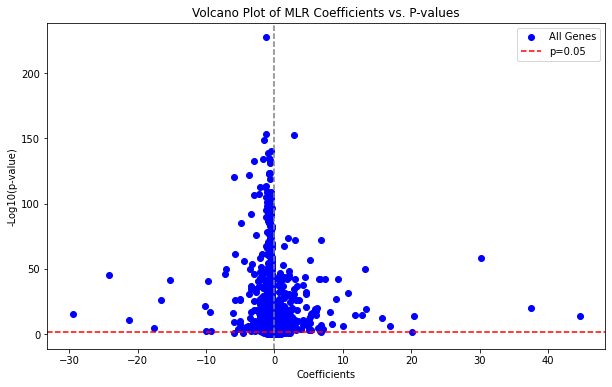

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     131.2
Date:                Mon, 18 Mar 2024   Prob (F-statistic):               0.00
Time:                        16:38:02   Log-Likelihood:            -2.3294e+05
No. Observations:              509437   AIC:                         4.680e+05
Df Residuals:                  508375   BIC:                         4.798e+05
Df Model:                        1061                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
TGGT1_000000_10      -0.4022      0.02

Generated dataset with 2071 graphs
Graph 1:
  Number of Genes: 1132
  Number of Cells: 383
  Genes present in this Graph: ['TGGT1_313050_2', 'TGGT1_207865_1', 'TGGT1_409250_65', 'TGGT1_212410_369', 'TGGT1_239600_2', 'TGGT1_286450_1', 'TGGT1_241000_3', 'TGGT1_254070_3', 'TGGT1_309560_2', 'TGGT1_211460_3']
  Gene Features:
    TGGT1_313050_2: 0.27443116903305054
    TGGT1_207865_1: 0.2491607666015625
    TGGT1_409250_65: 0.15954867005348206
    TGGT1_212410_369: 0.10238716751337051
    TGGT1_239600_2: 0.06835135817527771
    TGGT1_286450_1: 0.04653114452958107
    TGGT1_241000_3: 0.037952255457639694
    TGGT1_254070_3: 0.025923162698745728
    TGGT1_309560_2: 0.020514734089374542
    TGGT1_211460_3: 0.015199552290141582
  Cell Features (sample):
    Cell 1: 0.9459773302078247
    Cell 2: 0.9991469383239746
    Cell 3: 0.9993579983711243
    Cell 4: 0.9991311430931091
    Cell 5: 0.999658465385437
----------------------------------------
Graph 2:
  Number of Genes: 1132
  Number of Cells

  Genes present in this Graph: ['TGGT1_244280_2', 'TGGT1_000000_13', 'TGGT1_259700_1', 'TGGT1_236890_1', 'TGGT1_288000_2', 'TGGT1_215980_1', 'TGGT1_271270_2', 'TGGT1_000000_6', 'TGGT1_246590_3', 'TGGT1_203600_1', 'TGGT1_209170_3']
  Gene Features:
    TGGT1_244280_2: 0.0394955649971962
    TGGT1_000000_13: 0.04101995751261711
    TGGT1_259700_1: 0.11225055158138275
    TGGT1_236890_1: 0.17045454680919647
    TGGT1_288000_2: 0.0715077593922615
    TGGT1_215980_1: 0.08425720781087875
    TGGT1_271270_2: 0.05335365980863571
    TGGT1_000000_6: 0.2204822599887848
    TGGT1_246590_3: 0.10615299642086029
    TGGT1_203600_1: 0.061807096004486084
    TGGT1_209170_3: 0.03921840339899063
  Cell Features (sample):
    Cell 1: 0.9910804629325867
    Cell 2: 0.9994274377822876
    Cell 3: 0.9993818998336792
    Cell 4: 0.9950897097587585
    Cell 5: 0.9986729621887207
----------------------------------------
Graph 105:
  Number of Genes: 1132
  Number of Cells: 31
  Genes present in this Graph: ['T

  Number of Cells: 74
  Genes present in this Graph: ['TGGT1_408820_22', 'TGGT1_275850_2', 'TGGT1_288000_3', 'TGGT1_209170_1', 'TGGT1_215980_1', 'TGGT1_316280_2', 'TGGT1_241000_2']
  Gene Features:
    TGGT1_408820_22: 0.03519809618592262
    TGGT1_275850_2: 0.051861926913261414
    TGGT1_288000_3: 0.2877061665058136
    TGGT1_209170_1: 0.04387009143829346
    TGGT1_215980_1: 0.033157628029584885
    TGGT1_316280_2: 0.4208467900753021
    TGGT1_241000_2: 0.1273592859506607
  Cell Features (sample):
    Cell 1: 0.03372737020254135
    Cell 2: 0.9994983673095703
    Cell 3: 0.9953097701072693
    Cell 4: 0.9981508851051331
    Cell 5: 0.9906574487686157
----------------------------------------
Graph 195:
  Number of Genes: 1132
  Number of Cells: 69
  Genes present in this Graph: ['TGGT1_275440_1', 'TGGT1_411710_2', 'TGGT1_323320_36', 'TGGT1_000000_32', 'TGGT1_279350_1', 'TGGT1_215220_1', 'TGGT1_227810_3', 'TGGT1_305180_3', 'TGGT1_262400_1', 'TGGT1_235470_3', 'TGGT1_305590_1', 'TGGT1_264

  Number of Cells: 100
  Genes present in this Graph: ['TGGT1_410360_1', 'TGGT1_249470_1', 'TGGT1_411360_34', 'TGGT1_211260_2', 'TGGT1_215980_3']
  Gene Features:
    TGGT1_410360_1: 0.8733349442481995
    TGGT1_249470_1: 0.024218939244747162
    TGGT1_411360_34: 0.036812786012887955
    TGGT1_211260_2: 0.027367401868104935
    TGGT1_215980_3: 0.03826592490077019
  Cell Features (sample):
    Cell 1: 0.01837162859737873
    Cell 2: 0.9993308782577515
    Cell 3: 0.999599277973175
    Cell 4: 0.9980626702308655
    Cell 5: 0.9995993971824646
----------------------------------------
Graph 294:
  Number of Genes: 1132
  Number of Cells: 215
  Genes present in this Graph: ['TGGT1_201180B_1', 'TGGT1_408800_4', 'TGGT1_258230_3', 'TGGT1_272410_1', 'TGGT1_290040_1', 'TGGT1_245428_26']
  Gene Features:
    TGGT1_201180B_1: 0.09591642767190933
    TGGT1_408800_4: 0.10066476464271545
    TGGT1_258230_3: 0.14909781515598297
    TGGT1_272410_1: 0.1101614460349083
    TGGT1_290040_1: 0.3475783467292

  Number of Cells: 248
  Genes present in this Graph: ['TGGT1_411360_35', 'TGGT1_220950_3', 'TGGT1_236890_3', 'TGGT1_268970_2', 'TGGT1_310780_3', 'TGGT1_258870A_2', 'TGGT1_235130_3', 'TGGT1_204320_3', 'TGGT1_291630_3', 'TGGT1_201180A_1']
  Gene Features:
    TGGT1_411360_35: 0.050802137702703476
    TGGT1_220950_3: 0.159193754196167
    TGGT1_236890_3: 0.12011517584323883
    TGGT1_268970_2: 0.17071163654327393
    TGGT1_310780_3: 0.06190868094563484
    TGGT1_258870A_2: 0.02118469774723053
    TGGT1_235130_3: 0.0709584504365921
    TGGT1_204320_3: 0.03743315488100052
    TGGT1_291630_3: 0.15343479812145233
    TGGT1_201180A_1: 0.15425750613212585
  Cell Features (sample):
    Cell 1: 0.9980283379554749
    Cell 2: 0.8551557064056396
    Cell 3: 0.9950356483459473
    Cell 4: 0.999386191368103
    Cell 5: 0.9265268445014954
----------------------------------------
Graph 409:
  Number of Genes: 1132
  Number of Cells: 298
  Genes present in this Graph: ['TGGT1_309560_2', 'TGGT1_215775_3

  Genes present in this Graph: ['TGGT1_201180B_1', 'TGGT1_234540_2', 'TGGT1_411470_130', 'TGGT1_236800_2', 'TGGT1_323330_103', 'TGGT1_214420_2']
  Gene Features:
    TGGT1_201180B_1: 0.11852403730154037
    TGGT1_234540_2: 0.23443906009197235
    TGGT1_411470_130: 0.11889676004648209
    TGGT1_236800_2: 0.08572493493556976
    TGGT1_323330_103: 0.16101379692554474
    TGGT1_214420_2: 0.2814014256000519
  Cell Features (sample):
    Cell 1: 0.99891197681427
    Cell 2: 0.9991626739501953
    Cell 3: 0.9995228052139282
    Cell 4: 0.9996660947799683
    Cell 5: 0.9995543360710144
----------------------------------------
Graph 525:
  Number of Genes: 1132
  Number of Cells: 382
  Genes present in this Graph: ['TGGT1_239600_2', 'TGGT1_274170_1', 'TGGT1_299060_2', 'TGGT1_322000_3', 'TGGT1_240060_1']
  Gene Features:
    TGGT1_239600_2: 0.13359977304935455
    TGGT1_274170_1: 0.08221524208784103
    TGGT1_299060_2: 0.18955181539058685
    TGGT1_322000_3: 0.2783328592777252
    TGGT1_240060_1

  Genes present in this Graph: ['TGGT1_275460_2']
  Gene Features:
    TGGT1_275460_2: 1.0
  Cell Features (sample):
    Cell 1: 0.9971888661384583
    Cell 2: 0.9960567951202393
    Cell 3: 0.9989861845970154
    Cell 4: 0.9985302686691284
    Cell 5: 0.9975308775901794
----------------------------------------
Graph 647:
  Number of Genes: 1132
  Number of Cells: 55
  Genes present in this Graph: ['TGGT1_261740_3']
  Gene Features:
    TGGT1_261740_3: 1.0
  Cell Features (sample):
    Cell 1: 0.0031161680817604065
    Cell 2: 0.9389170408248901
    Cell 3: 0.1141916960477829
    Cell 4: 0.015798641368746758
    Cell 5: 0.003701635170727968
----------------------------------------
Graph 648:
  Number of Genes: 1132
  Number of Cells: 111
  Genes present in this Graph: ['TGGT1_244280_2']
  Gene Features:
    TGGT1_244280_2: 1.0
  Cell Features (sample):
    Cell 1: 0.030668510124087334
    Cell 2: 0.5606151819229126
    Cell 3: 0.001092934631742537
    Cell 4: 0.002656233264133334
    C

  Genes present in this Graph: ['TGGT1_244280_3', 'TGGT1_209170_3', 'TGGT1_258660_3']
  Gene Features:
    TGGT1_244280_3: 0.34708738327026367
    TGGT1_209170_3: 0.25485438108444214
    TGGT1_258660_3: 0.3980582654476166
  Cell Features (sample):
    Cell 1: 0.0009100140305235982
    Cell 2: 0.9984620809555054
    Cell 3: 0.9979481101036072
    Cell 4: 0.25730785727500916
    Cell 5: 0.6489506959915161
----------------------------------------
Graph 771:
  Number of Genes: 1132
  Number of Cells: 306
  Genes present in this Graph: ['TGGT1_409250_65', 'TGGT1_000000_10', 'TGGT1_000000_30', 'TGGT1_213050_1', 'TGGT1_411710_2', 'TGGT1_266050_2', 'TGGT1_235187B_1', 'TGGT1_309590_1', 'TGGT1_246590_1', 'TGGT1_295110_239', 'TGGT1_295110_64', 'TGGT1_229390_2', 'TGGT1_264660_1', 'TGGT1_204320_3', 'TGGT1_249770_1']
  Gene Features:
    TGGT1_409250_65: 0.04505482688546181
    TGGT1_000000_10: 0.08576701581478119
    TGGT1_000000_30: 0.014004994183778763
    TGGT1_213050_1: 0.10205189138650894
    

  Genes present in this Graph: ['TGGT1_266050_3', 'TGGT1_208450_2', 'TGGT1_290700_3', 'TGGT1_309590_1', 'TGGT1_202610_1', 'TGGT1_203290_2']
  Gene Features:
    TGGT1_266050_3: 0.1218053326010704
    TGGT1_208450_2: 0.24741707742214203
    TGGT1_290700_3: 0.10657966136932373
    TGGT1_309590_1: 0.16748233139514923
    TGGT1_202610_1: 0.24796085059642792
    TGGT1_203290_2: 0.10875476151704788
  Cell Features (sample):
    Cell 1: 0.7014260292053223
    Cell 2: 0.002083323895931244
    Cell 3: 0.002963806502521038
    Cell 4: 0.0037300135008990765
    Cell 5: 0.9985003471374512
----------------------------------------
Graph 887:
  Number of Genes: 1132
  Number of Cells: 30
  Genes present in this Graph: ['TGGT1_310780_3', 'TGGT1_252500_2']
  Gene Features:
    TGGT1_310780_3: 0.34328359365463257
    TGGT1_252500_2: 0.6567164063453674
  Cell Features (sample):
    Cell 1: 0.0005530930357053876
    Cell 2: 0.0473056398332119
    Cell 3: 0.0073511372320353985
    Cell 4: 0.995354413986206

  Genes present in this Graph: ['TGGT1_408800_1', 'TGGT1_263220_3', 'TGGT1_258462_1', 'TGGT1_247520_2', 'TGGT1_237500_1', 'TGGT1_251170_40', 'TGGT1_258225_3', 'TGGT1_290040_3']
  Gene Features:
    TGGT1_408800_1: 0.06366048008203506
    TGGT1_263220_3: 0.0506926029920578
    TGGT1_258462_1: 0.04155614599585533
    TGGT1_247520_2: 0.04155614599585533
    TGGT1_237500_1: 0.21573828160762787
    TGGT1_251170_40: 0.23253758251667023
    TGGT1_258225_3: 0.1402888298034668
    TGGT1_290040_3: 0.21396993100643158
  Cell Features (sample):
    Cell 1: 0.9993626475334167
    Cell 2: 0.9995630383491516
    Cell 3: 0.9991165995597839
    Cell 4: 0.999700665473938
    Cell 5: 0.9997790455818176
----------------------------------------
Graph 1010:
  Number of Genes: 1132
  Number of Cells: 82
  Genes present in this Graph: ['TGGT1_259700_1', 'TGGT1_251170_40']
  Gene Features:
    TGGT1_259700_1: 0.4962962865829468
    TGGT1_251170_40: 0.5037037134170532
  Cell Features (sample):
    Cell 1: 0.994

  Gene Features:
    TGGT1_263220_3: 1.0
  Cell Features (sample):
    Cell 1: 0.9985712766647339
    Cell 2: 0.9980325102806091
    Cell 3: 0.9997120499610901
    Cell 4: 0.1356540322303772
    Cell 5: 0.9961122870445251
----------------------------------------
Graph 1122:
  Number of Genes: 1132
  Number of Cells: 98
  Genes present in this Graph: ['TGGT1_286450_1', 'TGGT1_227010_1', 'TGGT1_247520_2', 'TGGT1_278878_3', 'TGGT1_411330_14', 'TGGT1_296000_2', 'TGGT1_241710_26']
  Gene Features:
    TGGT1_286450_1: 0.3082227110862732
    TGGT1_227010_1: 0.09481123834848404
    TGGT1_247520_2: 0.15307705104351044
    TGGT1_278878_3: 0.047578003257513046
    TGGT1_411330_14: 0.07929667085409164
    TGGT1_296000_2: 0.15273228287696838
    TGGT1_241710_26: 0.16428202390670776
  Cell Features (sample):
    Cell 1: 0.12873481214046478
    Cell 2: 0.9367245435714722
    Cell 3: 0.5415427088737488
    Cell 4: 0.998969554901123
    Cell 5: 0.9991064667701721
---------------------------------------

  Genes present in this Graph: ['TGGT1_312270_2', 'TGGT1_244490_2', 'TGGT1_365080_2', 'TGGT1_244280_2', 'TGGT1_258230_3', 'TGGT1_273980_1', 'TGGT1_207700_1', 'TGGT1_309760_1', 'TGGT1_298080_2', 'TGGT1_411710_3', 'TGGT1_000000_15', 'TGGT1_310780_3', 'TGGT1_366530_66', 'TGGT1_202200_2', 'TGGT1_296015_3', 'TGGT1_209170_1', 'TGGT1_223830_3', 'TGGT1_263220_2', 'TGGT1_201630B_3', 'TGGT1_225200_1']
  Gene Features:
    TGGT1_312270_2: 0.3806401193141937
    TGGT1_244490_2: 0.03582264855504036
    TGGT1_365080_2: 0.038856808096170425
    TGGT1_244280_2: 0.04228246957063675
    TGGT1_258230_3: 0.07321131229400635
    TGGT1_273980_1: 0.018694333732128143
    TGGT1_207700_1: 0.011647254228591919
    TGGT1_309760_1: 0.04198884218931198
    TGGT1_298080_2: 0.025937164202332497
    TGGT1_411710_3: 0.017519820481538773
    TGGT1_000000_15: 0.02300088107585907
    TGGT1_310780_3: 0.054223354905843735
    TGGT1_366530_66: 0.0645982176065445
    TGGT1_202200_2: 0.027698934078216553
    TGGT1_296015_3: 0

  Cell Features (sample):
    Cell 1: 0.9994357228279114
    Cell 2: 0.9995177984237671
    Cell 3: 0.9975500702857971
    Cell 4: 0.9994982481002808
    Cell 5: 0.9989995360374451
----------------------------------------
Graph 1283:
  Number of Genes: 1132
  Number of Cells: 128
  Genes present in this Graph: ['TGGT1_210095_1', 'TGGT1_408800_1', 'TGGT1_410610_97', 'TGGT1_411590_20', 'TGGT1_257050_1', 'TGGT1_290040_2', 'TGGT1_308093_126', 'TGGT1_295125_3', 'TGGT1_254070_1']
  Gene Features:
    TGGT1_210095_1: 0.05188094079494476
    TGGT1_408800_1: 0.1046920195221901
    TGGT1_410610_97: 0.12639521062374115
    TGGT1_411590_20: 0.06479950249195099
    TGGT1_257050_1: 0.12391483783721924
    TGGT1_290040_2: 0.1202976405620575
    TGGT1_308093_126: 0.07658123224973679
    TGGT1_295125_3: 0.2925795912742615
    TGGT1_254070_1: 0.03885903209447861
  Cell Features (sample):
    Cell 1: 0.999417781829834
    Cell 2: 0.9992362260818481
    Cell 3: 0.9973965883255005
    Cell 4: 0.99898952245

  Genes present in this Graph: ['TGGT1_411710_10', 'TGGT1_233695_2', 'TGGT1_203290_3', 'TGGT1_230470_1', 'TGGT1_408620_2', 'TGGT1_294970_1', 'TGGT1_201630B_3', 'TGGT1_275470_1']
  Gene Features:
    TGGT1_411710_10: 0.18331342935562134
    TGGT1_233695_2: 0.1728345900774002
    TGGT1_203290_3: 0.15373392403125763
    TGGT1_230470_1: 0.13927575945854187
    TGGT1_408620_2: 0.0326303206384182
    TGGT1_294970_1: 0.10120705515146255
    TGGT1_201630B_3: 0.07321926206350327
    TGGT1_275470_1: 0.14378564059734344
  Cell Features (sample):
    Cell 1: 0.0011924123391509056
    Cell 2: 0.9992204904556274
    Cell 3: 0.9979694485664368
    Cell 4: 0.7325437068939209
    Cell 5: 0.9921951293945312
----------------------------------------
Graph 1399:
  Number of Genes: 1132
  Number of Cells: 168
  Genes present in this Graph: ['TGGT1_211290_1', 'TGGT1_254070_2', 'TGGT1_243690_2', 'TGGT1_237015_3', 'TGGT1_237500_3']
  Gene Features:
    TGGT1_211290_1: 0.161112442612648
    TGGT1_254070_2: 0.04

    TGGT1_411410_126: 0.2903796434402466
    TGGT1_217400_3: 0.3190563917160034
    TGGT1_225200_1: 0.3147069811820984
  Cell Features (sample):
    Cell 1: 0.9993626475334167
    Cell 2: 0.9996777772903442
    Cell 3: 0.0011729705147445202
    Cell 4: 0.9994231462478638
    Cell 5: 0.9997397065162659
----------------------------------------
Graph 1520:
  Number of Genes: 1132
  Number of Cells: 662
  Genes present in this Graph: ['TGGT1_230180_1', 'TGGT1_203990_2', 'TGGT1_208450_3', 'TGGT1_308970_1']
  Gene Features:
    TGGT1_230180_1: 0.3202054798603058
    TGGT1_203990_2: 0.03852739557623863
    TGGT1_208450_3: 0.24029681086540222
    TGGT1_308970_1: 0.40097030997276306
  Cell Features (sample):
    Cell 1: 0.9931154847145081
    Cell 2: 0.9960629343986511
    Cell 3: 0.06020549684762955
    Cell 4: 0.008929869160056114
    Cell 5: 0.9993256330490112
----------------------------------------
Graph 1521:
  Number of Genes: 1132
  Number of Cells: 500
  Genes present in this Graph: ['

  Genes present in this Graph: ['TGGT1_309560_2', 'TGGT1_247220_2']
  Gene Features:
    TGGT1_309560_2: 0.4068090617656708
    TGGT1_247220_2: 0.5931909680366516
  Cell Features (sample):
    Cell 1: 0.9996936321258545
    Cell 2: 0.9992135763168335
    Cell 3: 0.9992997646331787
    Cell 4: 0.9996110796928406
    Cell 5: 0.9996150732040405
----------------------------------------
Graph 1639:
  Number of Genes: 1132
  Number of Cells: 334
  Genes present in this Graph: ['TGGT1_208830_1', 'TGGT1_215775_3', 'TGGT1_366530_66', 'TGGT1_254080_3', 'TGGT1_248140_2']
  Gene Features:
    TGGT1_208830_1: 0.014517847448587418
    TGGT1_215775_3: 0.39464572072029114
    TGGT1_366530_66: 0.13518913090229034
    TGGT1_254080_3: 0.1995205134153366
    TGGT1_248140_2: 0.2561267912387848
  Cell Features (sample):
    Cell 1: 0.9997066855430603
    Cell 2: 0.9273626208305359
    Cell 3: 0.9995779395103455
    Cell 4: 0.9995056390762329
    Cell 5: 0.999640703201294
------------------------------------

  Genes present in this Graph: ['TGGT1_309560_2', 'TGGT1_254880_3', 'TGGT1_227280_1', 'TGGT1_259700_1', 'TGGT1_222100_2', 'TGGT1_265120_2', 'TGGT1_366530_100']
  Gene Features:
    TGGT1_309560_2: 0.16716867685317993
    TGGT1_254880_3: 0.11596385389566422
    TGGT1_227280_1: 0.05572289228439331
    TGGT1_259700_1: 0.05170682817697525
    TGGT1_222100_2: 0.13704819977283478
    TGGT1_265120_2: 0.2881526052951813
    TGGT1_366530_100: 0.18423694372177124
  Cell Features (sample):
    Cell 1: 0.7367109060287476
    Cell 2: 0.0007241160492412746
    Cell 3: 0.009327096864581108
    Cell 4: 0.13977016508579254
    Cell 5: 0.7998561859130859
----------------------------------------
Graph 1755:
  Number of Genes: 1132
  Number of Cells: 193
  Genes present in this Graph: ['TGGT1_203310_2', 'TGGT1_273980_1', 'TGGT1_408800_3', 'TGGT1_243690_4', 'TGGT1_272000_3', 'TGGT1_234950_1']
  Gene Features:
    TGGT1_203310_2: 0.09422936290502548
    TGGT1_273980_1: 0.10810811072587967
    TGGT1_408800_3

  Genes present in this Graph: ['TGGT1_203310_2', 'TGGT1_225160_2', 'TGGT1_242600_3']
  Gene Features:
    TGGT1_203310_2: 0.6246684193611145
    TGGT1_225160_2: 0.1697612702846527
    TGGT1_242600_3: 0.2055702954530716
  Cell Features (sample):
    Cell 1: 0.9995633959770203
    Cell 2: 0.9997530579566956
    Cell 3: 0.9988127946853638
    Cell 4: 0.9979608058929443
    Cell 5: 0.9981380701065063
----------------------------------------
Graph 1865:
  Number of Genes: 1132
  Number of Cells: 238
  Genes present in this Graph: ['TGGT1_203310_2', 'TGGT1_225160_2', 'TGGT1_242600_3', 'TGGT1_278882_2', 'TGGT1_411410_24']
  Gene Features:
    TGGT1_203310_2: 0.48883572220802307
    TGGT1_225160_2: 0.10047847032546997
    TGGT1_242600_3: 0.12121212482452393
    TGGT1_278882_2: 0.08931419253349304
    TGGT1_411410_24: 0.20015949010849
  Cell Features (sample):
    Cell 1: 0.07034412771463394
    Cell 2: 0.0005389356520026922
    Cell 3: 0.0829622820019722
    Cell 4: 0.9948318004608154
    Cel

    Cell 5: 0.9977290034294128
----------------------------------------
Graph 1977:
  Number of Genes: 1132
  Number of Cells: 179
  Genes present in this Graph: ['TGGT1_203310_2', 'TGGT1_225160_2', 'TGGT1_242600_3', 'TGGT1_411410_24']
  Gene Features:
    TGGT1_203310_2: 0.5311803817749023
    TGGT1_225160_2: 0.12026725709438324
    TGGT1_242600_3: 0.11692650616168976
    TGGT1_411410_24: 0.23162584006786346
  Cell Features (sample):
    Cell 1: 0.934960126876831
    Cell 2: 0.9222186803817749
    Cell 3: 0.004061998333781958
    Cell 4: 0.8588846921920776
    Cell 5: 0.7625340819358826
----------------------------------------
Graph 1978:
  Number of Genes: 1132
  Number of Cells: 212
  Genes present in this Graph: ['TGGT1_203310_2', 'TGGT1_225160_2', 'TGGT1_242600_3', 'TGGT1_278882_2', 'TGGT1_411410_24']
  Gene Features:
    TGGT1_203310_2: 0.45287540555000305
    TGGT1_225160_2: 0.13178913295269012
    TGGT1_242600_3: 0.103833869099617
    TGGT1_278882_2: 0.0854632556438446
    TGGT

In [26]:
sequencing = '/mnt/data/CellVoyager/20x/tsg101/crispr_screen/all/measurements/sequencing.csv'
scores = '/mnt/data/CellVoyager/20x/tsg101/crispr_screen/all/measurements/dv_cell.csv'

graphs, gene_id_to_index = generate_graphs(sequencing, scores, cell_min=25, gene_min_read=75, test=False)
print_graphs_info(graphs, gene_id_to_index)

In [14]:
model = train_graph_transformer(graphs,
                        lr=0.001,
                        dropout_rate=0.05,
                        epochs=100,
                        save_fldr='/home/olafsson/Desktop/gnn',
                        acc_threshold = 0.25)

Training log saved to /home/olafsson/Desktop/gnn/training_log.csv6
Model saved to /home/olafsson/Desktop/gnn/model.pth


In [15]:
result = annotate_cells_with_genes(graphs, model, gene_id_to_index)

In [16]:
result

,Cell ID,Most Probable Gene,Cell Score,Predicted Cell Score,Probability Score for Highest Gene
0,0,gene_336,0.492047,0.654213,0.001004
1,1,gene_336,0.854099,0.654213,0.001005
2,2,gene_336,0.617010,0.654213,0.001004
3,3,gene_336,0.551446,0.654213,0.001004
4,4,gene_336,0.759337,0.654213,0.001004
...,...,...,...,...,...
749960,538,gene_438,0.154578,0.642884,0.001008
749961,539,gene_438,0.030933,0.642884,0.001008
749962,540,gene_438,0.316369,0.642884,0.001009
749963,541,gene_438,0.737749,0.642884,0.001010


In [17]:
grouped_stats = result.groupby('Most Probable Gene').agg({
    'Cell Score': ['mean', 'median', 'std', 'count'],
    'Predicted Cell Score': ['mean', 'median', 'std', 'count'],
    'Probability Score for Highest Gene': ['mean', 'median', 'std', 'count']
})

In [18]:
grouped_stats

Cell Score                           Predicted Cell Score  \
                         mean    median       std count                 mean   
Most Probable Gene                                                             
gene_1               0.495093  0.499511  0.291237   925             0.646037   
gene_10              0.501166  0.511827  0.285357   544             0.656295   
gene_1000            0.491443  0.489959  0.290067  2623             0.656774   
gene_102             0.509016  0.528004  0.294567   495             0.645816   
gene_103             0.493322  0.500253  0.289149   562             0.649814   
...                       ...       ...       ...   ...                  ...   
gene_991             0.495482  0.481468  0.286987   466             0.656338   
gene_992             0.503836  0.501975  0.288604  1501             0.651446   
gene_994             0.505100  0.505247  0.289436   916             0.649186   
gene_995             0.475304  0.447998  0.294165   484             0.649961   
gene_998             0.513202  0.505702  0.277939   516             0.645109   

                                              \
                      median       std count   
Most Probable Gene                             
gene_1              0.651946  0.006441   925   
gene_10             0.656295  0.000000   544   
gene_1000           0.652256  0.006825  2623   
gene_102            0.645816  0.000000   495   
gene_103            0.649814  0.000000   562   
...                      ...       ...   ...   
gene_991            0.656338  0.000000   466   
gene_992            0.652067  0.000981  1501   
gene_994            0.654170  0.005232   916   
gene_995            0.649961  0.000000   484   
gene_998            0.645109  0.000000   516   

                   Probability Score for Highest Gene                          \
                                                 mean    median           std   
Most Probable Gene                                                              
gene_1                                       0.001008  0.001008  1.285957e-06   
gene_10                                      0.001006  0.001006  4.169218e-07   
gene_1000                                    0.001007  0.001006  2.163999e-06   
gene_102                                     0.001006  0.001006  4.443663e-07   
gene_103                                     0.001008  0.001008  6.772872e-07   
...                                               ...       ...           ...   
gene_991                                     0.001007  0.001007  4.625868e-07   
gene_992                                     0.001006  0.001006  8.964541e-07   
gene_994                                     0.001007  0.001006  8.093379e-07   
gene_995                                     0.001007  0.001007  5.803320e-07   
gene_998                                     0.001010  0.001010  9.752323e-07   

                          
                   count  
Most Probable Gene        
gene_1               925  
gene_10              544  
gene_1000           2623  
gene_102             495  
gene_103             562  
...                  ...  
gene_991             466  
gene_992            1501  
gene_994             916  
gene_995             484  
gene_998             516  

[771 rows x 12 columns]

In [19]:
for col in grouped_stats.columns:
    print(col)

('Cell Score', 'mean')
('Cell Score', 'median')
('Cell Score', 'std')
('Cell Score', 'count')
('Predicted Cell Score', 'mean')
('Predicted Cell Score', 'median')
('Predicted Cell Score', 'std')
('Predicted Cell Score', 'count')
('Probability Score for Highest Gene', 'mean')
('Probability Score for Highest Gene', 'median')
('Probability Score for Highest Gene', 'std')
('Probability Score for Highest Gene', 'count')


In [22]:
sorted_df = grouped_stats.sort_values(by=('Predicted Cell Score', 'median'), ascending=False)
sorted_df

Cell Score                           Predicted Cell Score  \
                         mean    median       std count                 mean   
Most Probable Gene                                                             
gene_408             0.503816  0.521123  0.295709  1028             0.659538   
gene_341             0.505422  0.503831  0.287478  1112             0.660992   
gene_458             0.514535  0.523139  0.297827   505             0.670708   
gene_883             0.500648  0.517200  0.286279   534             0.670613   
gene_182             0.500492  0.503464  0.298448   528             0.668639   
...                       ...       ...       ...   ...                  ...   
gene_436             0.500870  0.492666  0.298091   555             0.633207   
gene_660             0.508193  0.547041  0.283723   437             0.632735   
gene_524             0.495418  0.497831  0.288304   965             0.641691   
gene_895             0.486562  0.481067  0.281904   518             0.631558   
gene_141             0.497397  0.506593  0.289559  1088             0.642898   

                                              \
                      median       std count   
Most Probable Gene                             
gene_408            0.672738  0.013414  1028   
gene_341            0.670750  0.010341  1112   
gene_458            0.670708  0.000000   505   
gene_883            0.670613  0.000000   534   
gene_182            0.668639  0.000000   528   
...                      ...       ...   ...   
gene_436            0.633207  0.000000   555   
gene_660            0.632735  0.000000   437   
gene_524            0.631848  0.010107   965   
gene_895            0.631558  0.000000   518   
gene_141            0.628569  0.014873  1088   

                   Probability Score for Highest Gene                          \
                                                 mean    median           std   
Most Probable Gene                                                              
gene_408                                     0.001005  0.001004  1.234328e-06   
gene_341                                     0.001005  0.001004  1.436673e-06   
gene_458                                     0.001004  0.001004  2.448883e-07   
gene_883                                     0.001004  0.001004  2.436741e-07   
gene_182                                     0.001006  0.001006  3.831734e-07   
...                                               ...       ...           ...   
gene_436                                     0.001012  0.001013  1.538878e-06   
gene_660                                     0.001012  0.001013  1.497460e-06   
gene_524                                     0.001009  0.001009  3.400459e-06   
gene_895                                     0.001012  0.001012  1.368585e-06   
gene_141                                     0.001009  0.001009  4.160125e-06   

                          
                   count  
Most Probable Gene        
gene_408            1028  
gene_341            1112  
gene_458             505  
gene_883             534  
gene_182             528  
...                  ...  
gene_436             555  
gene_660             437  
gene_524             965  
gene_895             518  
gene_141            1088  

[771 rows x 12 columns]

In [ ]:
class MPNN(MessagePassing):
    def __init__(self, node_in_features, edge_in_features, out_features):
        super(MPNN, self).__init__(aggr='mean')  # 'mean' aggregation.
        self.message_mlp = Sequential(
            Linear(node_in_features + edge_in_features, 128),
            ReLU(),
            Linear(128, out_features)
        )
        self.update_mlp = Sequential(
            Linear(out_features, out_features),
            ReLU(),
            Linear(out_features, out_features)
        )

    def forward(self, x, edge_index, edge_attr):
        # x: Node features [N, node_in_features]
        # edge_index: Graph connectivity [2, E]
        # edge_attr: Edge attributes/features [E, edge_in_features]
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_j, edge_attr):
        # x_j: Input features of neighbors [E, node_in_features]
        # edge_attr: Edge attributes [E, edge_in_features]
        tmp = torch.cat([x_j, edge_attr], dim=-1)  # Concatenate node features with edge attributes
        return self.message_mlp(tmp)

    def update(self, aggr_out):
        # aggr_out: Aggregated messages [N, out_features]
        return self.update_mlp(aggr_out)
    
def weighted_mse_loss(output, target, score_threshold=0.8, high_score_weight=10):
    # Assumes output and target are the predicted and true scores, respectively
    weights = torch.ones_like(target)
    high_score_mask = target >= score_threshold
    weights[high_score_mask] = high_score_weight
    return ((output - target) ** 2 * weights).mean()

def generate_single_graph(sequencing, scores):
    # Load and preprocess sequencing data
    gene_df = pd.read_csv(sequencing)
    gene_df = gene_df.rename(columns={"prc": "well_id", "grna": "gene_id", "count": "read_count"})
    total_reads_per_well = gene_df.groupby('well_id')['read_count'].sum().reset_index(name='total_reads')
    gene_df = gene_df.merge(total_reads_per_well, on='well_id')
    gene_df['well_read_fraction'] = gene_df['read_count']/gene_df['total_reads']

    # Load and preprocess cell score data
    cell_df = pd.read_csv(scores)
    cell_df = cell_df[['prcfo', 'prc', 'pred']].rename(columns={'prcfo': 'cell_id', 'prc': 'well_id', 'pred': 'score'})

    # Initialize mappings
    gene_id_to_index = {gene: i for i, gene in enumerate(gene_df['gene_id'].unique())}
    cell_id_to_index = {cell: i + len(gene_id_to_index) for i, cell in enumerate(cell_df['cell_id'].unique())}

    # Initialize edge indices and attributes
    edge_index = []
    edge_attr = []

    # Associate each cell with all genes in the same well
    for well_id, group in gene_df.groupby('well_id'):
        if well_id in cell_df['well_id'].values:
            cell_indices = cell_df[cell_df['well_id'] == well_id]['cell_id'].map(cell_id_to_index).values
            gene_indices = group['gene_id'].map(gene_id_to_index).values
            fractions = group['well_read_fraction'].values
            
            for cell_idx in cell_indices:
                for gene_idx, fraction in zip(gene_indices, fractions):
                    edge_index.append([cell_idx, gene_idx])
                    edge_attr.append([fraction])

    # Convert lists to PyTorch tensors
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    cell_scores = torch.tensor(cell_df['score'].values, dtype=torch.float)

    # One-hot encoding for genes, and zero features for cells (could be replaced with real features if available)
    gene_features = torch.eye(len(gene_id_to_index))
    cell_features = torch.zeros(len(cell_id_to_index), gene_features.size(1))

    # Combine features
    x = torch.cat([cell_features, gene_features], dim=0)

    # Create the graph data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=cell_scores)

    return data, gene_id_to_index, len(gene_id_to_index)

In [ ]:
import pickle
import numpy as np
import pandas as pd
from torch_geometric.data import Data
from collections import defaultdict
import torch
from torch.nn import Sequential, Linear, ReLU
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.utils import degree, add_self_loops, softmax
from torch_geometric.loader import DataLoader, NeighborSampler
from sklearn.metrics import mean_squared_error
from torch_geometric.nn import SAGEConv, global_mean_pool, Linear, TransformerConv, GCNConv, GATConv, MessagePassing
from torch import Tensor, nn
from torch_geometric.data import Batch
from torch.utils.data import DataLoader as TorchDataLoader
from torch.nn import Linear, Module
import torch
import torch.nn.functional as F
from torch.nn import Linear, Module
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn.inits import reset
from torch_geometric.nn.conv import MessagePassing

def collate(batch):
    data_list = [data for _, data in batch]
    return Batch.from_data_list(data_list)


def generate_well_graphs(sequencing, scores):
    # Load and preprocess sequencing data
    gene_df = pd.read_csv(sequencing)
    gene_df = gene_df.rename(columns={'prc': 'well_id', 'grna': 'gene_id', 'count': 'read_count'})
    total_reads_per_well = gene_df.groupby('well_id')['read_count'].sum().reset_index(name='total_reads')
    gene_df = gene_df.merge(total_reads_per_well, on='well_id')
    gene_df['well_read_fraction'] = gene_df['read_count'] / gene_df['total_reads']

    # Load and preprocess cell score data
    cell_df = pd.read_csv(scores)
    cell_df = cell_df[['prcfo', 'prc', 'pred']].rename(columns={'prcfo': 'cell_id', 'prc': 'well_id', 'pred': 'score'})

    # Initialize mappings
    gene_id_to_index = {gene: i for i, gene in enumerate(gene_df['gene_id'].unique())}
    cell_id_to_index = {cell: i + len(gene_id_to_index) for i, cell in enumerate(cell_df['cell_id'].unique())}

    # Initialize a dictionary to store edge information for each well subgraph
    wells_subgraphs = defaultdict(lambda: {'edge_index': [], 'edge_attr': []})

    # Associate each cell with all genes in the same well
    for well_id, group in gene_df.groupby('well_id'):
        if well_id in cell_df['well_id'].values:
            cell_indices = cell_df[cell_df['well_id'] == well_id]['cell_id'].map(cell_id_to_index).values
            gene_indices = group['gene_id'].map(gene_id_to_index).values
            fractions = group['well_read_fraction'].values

            for cell_idx in cell_indices:
                for gene_idx, fraction in zip(gene_indices, fractions):
                    wells_subgraphs[well_id]['edge_index'].append([cell_idx, gene_idx])
                    wells_subgraphs[well_id]['edge_attr'].append([fraction])

    # Process well subgraphs into PyTorch Geometric Data objects
    well_data_list = []
    for well_id, subgraph in wells_subgraphs.items():
        edge_index = torch.tensor(subgraph['edge_index'], dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(subgraph['edge_attr'], dtype=torch.float)
        num_nodes = max(max(edge) for edge in subgraph['edge_index']) + 1
        x = torch.ones((num_nodes, 1))  # Feature matrix with a single feature set to 1 for each node

        # Retrieve cell scores for the current well
        cell_scores = cell_df[cell_df['well_id'] == well_id]['score'].values
        # Create a tensor for cell scores, ensuring the order matches that of the nodes in the graph
        y = torch.tensor(cell_scores, dtype=torch.float)
        
        subgraph_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
        well_data_list.append((well_id, subgraph_data))
    
    return well_data_list, gene_id_to_index, len(gene_id_to_index), cell_id_to_index

class CustomTransformerConv(MessagePassing):
    def __init__(self, in_channels, out_channels, heads=1, concat=True, beta=False, dropout=0.0, edge_dim=None):
        super().__init__(node_dim=0, aggr='add')  # Specify aggregation
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.concat = concat
        self.beta = beta
        self.dropout = dropout
        self.edge_dim = edge_dim

        # The linear layers for the multi-head attention mechanism
        self.lin_query = Linear(in_channels, heads * out_channels, bias=False)
        self.lin_key = Linear(in_channels, heads * out_channels, bias=False)
        self.lin_value = Linear(in_channels, heads * out_channels, bias=False)

        # Optional edge transformation
        if edge_dim is not None:
            self.lin_edge = Linear(edge_dim, heads * out_channels, bias=False)

        # Optional beta parameter for combining aggregation and skip connection
        if self.beta:
            self.lin_gate = torch.nn.Linear(in_channels + out_channels, 1, bias=True)
        
        # The final linear transformation that is applied to each node feature vector
        self.lin_out = Linear(heads * out_channels, out_channels, bias=True) if concat else Linear(out_channels, out_channels, bias=True)

        # For storing the attention weights
        self.att = None 

        # Initialize the parameters
        self.reset_parameters()

    def reset_parameters(self):
        # Reset the parameters here
        self.lin_query.reset_parameters()
        self.lin_key.reset_parameters()
        self.lin_value.reset_parameters()
        if self.edge_dim is not None:
            self.lin_edge.reset_parameters()
        if self.beta:
            self.lin_gate.reset_parameters()
        self.lin_out.reset_parameters()

    def forward(self, x, edge_index, edge_attr=None):
        print(f"Input features shape: {x.shape}")
        query = self.lin_query(x).view(-1, self.heads, self.out_channels)
        query = self.lin_query(x)
        print(f"Query shape (pre-view): {query.shape}")
        key = self.lin_key(x).view(-1, self.heads, self.out_channels)
        value = self.lin_value(x).view(-1, self.heads, self.out_channels)
        
        # Propagate the messages
        out = self.propagate(edge_index, x=(query, key, value), edge_attr=edge_attr, size=None)
        
        # Reshape and concatenate head outputs if required
        if self.concat:
            out = out.view(-1, self.heads * self.out_channels)
        else:
            out = out.mean(dim=1)
        
        # Apply root node transformation with skip connection if required
        if self.root_weight:
            out = out + self.lin_root(x[:out.size(0), :])
        
        return out

    def message(self, x_j, x_i, edge_attr, index, ptr, size_i):
        # Compute messages
        # This needs to be implemented based on your model's specifics
        query, key, value = x_i[0], x_j[1], x_j[2]
        # Compute the attention scores
        alpha = (query * key).sum(dim=-1) / self.scale
        alpha = softmax(alpha, index, ptr, size_i)
        
        # Apply attention scores to the values
        out = value * alpha.view(-1, self.heads, 1)
        return out.view(-1, self.heads * self.out_channels)


class GraphTransformer(torch.nn.Module):
    def __init__(self, num_node_features, dropout_rate=0.1):
        super(GraphTransformer, self).__init__()
        # Assuming you want to predict a single value per graph, adjust the out_channels as needed.
        num_heads = 4  # Example: 4 attention heads
        out_channels = 1  # Example: predicting a single score per graph
        self.conv1 = CustomTransformerConv(num_node_features, 128, heads=num_heads, dropout=dropout_rate, edge_dim=1)
        self.conv2 = CustomTransformerConv(128 * num_heads, 256, heads=num_heads, dropout=dropout_rate, edge_dim=1)
        self.lin = Linear(256 * num_heads, out_channels)  # Adjusted for a single output feature

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        # Here we call forward on the CustomTransformerConv.
        # Make sure edge_attr is only passed if you have edge features.
        # Adjust the head dimensions and any additional logic based on your architecture.

        x = F.relu(self.conv1(x, edge_index, edge_attr=edge_attr))
        # more layers...

        return x

def train_graph_network(graph_data_list, feature_size, model_path, batch_size=8, epochs=100, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GraphTransformer(num_node_features=feature_size).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss(reduction='mean')

    data_loader = TorchDataLoader(graph_data_list, batch_size=batch_size, shuffle=True, collate_fn=collate)
    
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data in data_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out.view(-1), data.y.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(data_loader)}')
    
    torch.save(model.state_dict(), model_path)

In [ ]:
train_graph_network(graph_data_list=graph_data,
                    feature_size=feature_size,
                    model_path='/home/olafsson/Desktop/gnn/model/pth',
                    batch_size=8,
                    epochs=100,
                    lr=0.001)

In [ ]:
sequencing = '/mnt/data/CellVoyager/20x/tsg101/crispr_screen/all/measurements/sequencing.csv'
scores = '/mnt/data/CellVoyager/20x/tsg101/crispr_screen/all/measurements/dv_cell.csv'
graph_data, gene_id_to_index, feature_size, cell_id_to_index = generate_well_graphs(sequencing,scores)

In [ ]:
model_save_path = '/home/olafsson/Desktop/gnn/mode.pth'
compute_gene_importance(model,
                        graph_data,
                        model_save_path,
                        n_permutations=10)

In [ ]:
sequencing = '/mnt/data/CellVoyager/20x/tsg101/crispr_screen/all/measurements/sequencing.csv'
score = '/mnt/data/CellVoyager/20x/tsg101/crispr_screen/all/measurements/dv_cell.csv'

# Example loading step
gene_df = pd.read_csv(sequencing)
cell_df = pd.read_csv(score)

gene_df = gene_df.rename(columns={"prc": "well_id", "grna": "gene_id", "count": "read_count"})
gene_df = gene_df.drop(columns=['Unnamed: 0', 'plate', 'row', 'col', 'grna_seq', 'gene'])
total_reads_per_well = gene_df.groupby('well_id')['read_count'].sum().reset_index(name='total_reads')
gene_df = gene_df.merge(total_reads_per_well, on='well_id')
gene_df['well_read_fraction'] = gene_df['read_count']/gene_df['total_reads']
gene_df = gene_df.drop(columns=['read_count', 'total_reads'])

cell_df = cell_df.rename(columns={"prcfo": "cell_id", "prc": "well_id", "pred": "score"})
cell_df = cell_df.drop(columns=['parasite_area', 'parasite_area', 'recruitment'])
display(gene_df)
display(cell_df)
feature_size = len(gene_df['gene_id'].unique())
feature_size

In [ ]:
print(f'feature_size: {feature_size}')
graph_data, gene_id_to_index = generate_graph(gene_df,cell_df)
dict_file_path = '/home/olafsson/Desktop/gnn/dict.pth'

with open(dict_file_path, 'wb') as file:
    pickle.dump(gene_id_to_index, file)

In [ ]:
'pip install torch-sparse -f https://data.pyg.org/whl/torch-2.2.1+cu121.html'
'pip install torch-scatter -f https://data.pyg.org/whl/torch-2.2.1+cu121.html'
print(f'feature_size: {feature_size}')

dict_file_path = '/home/olafsson/Desktop/gnn/dict.pth'

with open(dict_file_path, 'wb') as file:
    pickle.dump(gene_id_to_index, file)

In [ ]:
I first transect a library of gRNAs targeting ~1400 genes into Toxoplasma tachyzoites and grow the parasites under selection for 1 week. This generates a pooled population of mutant parasites, each parasite is missing one gene. I then seed HFF cells in 384 well plates and transfer 10 mutants on average to each well. These parasites grow for a few days to generate sub-pools of parasite populations consisting of on average 10 unique mutants. At this point i transfer mutants to corresponding wells in new 384 well plates, these plates have cells that the parasites will infect. I then fix, stain and image these new plates. The rest of the parasites in the original 384 well plates are sequenced so i know which mutants were present in each well. Single cell images are then cropped from each field of view classified by a CNN. I only include cells infected by one parasite. So at the end of the experiment i have infected cells infected by 1 mutant parasite with phenotype scores and i know the genes that are knocked out in the parasites in each well. I also know the relative abundance of each mutant in each well through the proportion of sequencing reads in each well. 